In [2]:
# JSS
## TODO 
#using pca to reduce the dimensionality of the global descriptors
#using MobileVnet instead of netVLAD
#using hfnet instead of netVlAD and MobileVnet --that is not working 
# this will also help reduce the complexity 
#understand what superglue is outputting
# getting two models from SFM 
# Setting up the scale of the model -- this is done easy and simple
import numpy as np
import argparse
import yaml
import logging
from pathlib import Path
from tqdm import tqdm
from pprint import pformat
import h5py
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from notebooks.utils import plot_images, plot_matches, add_frame
from hfnet.models import get_model  
# send the path to the image directory and get the path to all the images in it
def image_directory_parser(path, viewer=True, number= 4):    
    globs=['*.jpg', '*.png', '*.jpeg', '*.JPG', '*.PNG']
    ## can also use sufix instead of with method
    image_path = []
    for g in globs:
        image_path += list(path.glob("**/"+g))
    if viewer:
        nrows = number
        ncols = number
        fig = plt.gcf()
        fig.set_size_inches(ncols*4, ncols*4)
        for i in range(2*number):
            sp = plt.subplot(nrows, ncols, i + 1)
            sp.axis('Off') # Don't show axes (or gridlines)
            img = mpimg.imread((image_path[i]))
            plt.imshow(img)
        plt.show()
    return image_path
# image dictionary creator gives image, its name and index as dictionary
def dictionary_of_images(image_path):
    image_dict ={}
    for i,j in tqdm(enumerate(image_path)):
        image_array = cv2.imread(str(j))
#         print(image_path[i].name)
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_dict[i] = {"image":image_array, "name": image_path[i].name, "number": i}
    return image_dict
# this finds the global matrix and 
def global_dict_matrix_and_H5_map(config, image_dict):
    predictions_dict = {}
    global_feature_path = (config["output"])/"global_features.h5"
    global_feature_file = h5py.File(str(global_feature_path), 'w')
    checkpoint_path = Path(config["checkpoint_path"])
    keys = ['global_descriptor']    
    with get_model(config['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path))
        for i in tqdm(range(len(image_dict))):
            data = image_dict[i] ## selecting using index
            predictions = net.predict(data, keys=keys)
            predictions_dict[i] = {"global_descriptor":predictions['global_descriptor'], "name" : data['name']}   
            if i == 0:
                global_matrix = np.array(predictions['global_descriptor'])
            else:
                global_matrix = np.vstack((global_matrix,predictions['global_descriptor']))
            grp = global_feature_file.create_group(data['name'])
            grp.create_dataset('global_descriptor', data=predictions['global_descriptor'])
        global_feature_file.close()
    return predictions_dict, global_matrix
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)
## needs both global matrix and dict as we need to give names too
## I am idiot if I keep wiritng codes like this one lol ;)
# Need to change it hehehe
# Writing the .txt file.
def text_file_for_global_matches(global_feature_dict, global_feature_matrix, path, number): 
    predictions_dict_matches = {}
    for i in tqdm(range(len(global_feature_dict))):
        current_descriptor = global_feature_matrix[i, :]
        neighbours = compute_distance(current_descriptor, global_feature_matrix)
        predictions_dict_matches[i] = ((np.argsort(neighbours))[:number])[1 :]
    #first writing the file
    output_file_txt = path/"global_feature.txt"
    with open(output_file_txt, 'w') as f:
        for i in tqdm(range(len(predictions_dict_matches))):
            current_image_name = global_feature_dict[i]["name"]
            current_image_matches = predictions_dict_matches[i]
            string_list = []
            for j in range(len(current_image_matches)):
                    if i == 0 and j ==0:
                        making_a_string = current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    
                    else: 
                        making_a_string = "\n" + current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    f.write(making_a_string)  
    ## checking common lines and rewriting
    image_list_for_finding_common_separated = []
    with open(output_file_txt, 'r') as f:
        image_list_for_finding_common = [l.strip() for l in f]
    for i in range(len(image_list_for_finding_common)):
        current_index_value = image_list_for_finding_common[i]
        current_index_value = list(current_index_value.split(" "))
        image_list_for_finding_common_separated.append(sorted(current_index_value))
    ilf = sorted(image_list_for_finding_common_separated)
    final_list = []
    for i in range(len(ilf)):
        if ilf[i] in final_list:
            pass
        else:
            final_list.append(ilf[i])
    with open(output_file_txt, 'w') as f:
        for i in range(len(final_list)):
            if i == 0:
                making_a_string = final_list[i][0]+ " " + final_list[i][1]
            else:
                making_a_string = "\n" + final_list[i][0]+ " " + final_list[i][1]
            f.write(making_a_string)

In [3]:
path_to_images_for_map = Path('/home/Hierarchical-Localization/H_Loop_Chennai/masked')

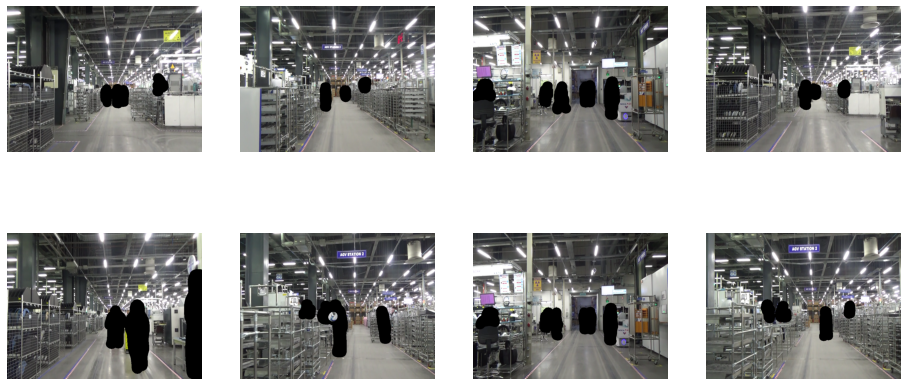

In [4]:
image_path = image_directory_parser(path_to_images_for_map, viewer=True, number = 4)

In [4]:
image_dict = dictionary_of_images(image_path)

2917it [00:32, 90.76it/s]


In [5]:
output_path = Path("/home/Hierarchical-Localization/outputs/sfm_H_chennai_masking")
# output_path.mkdir()

checkpoint_path = Path("/home/Hierarchical-Localization/weights/vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white")

In [7]:
config_global = {'output':output_path, 'checkpoint_path':checkpoint_path, 'data': {'name': 'aachen', 'load_db': False, 'load_queries': True, 'resize_max': 960}, 'model': {'name': 'netvlad_original', 'local_descriptor_layer': 'conv3_3', 'image_channels': 1}, 'weights': 'vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white'}         
global_dict_map, global_matrix = global_dict_matrix_and_H5_map(config_global, image_dict)

W0213 07:36:08.148151 140055230490432 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:104: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0213 07:36:08.172098 140055230490432 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0213 07:36:08.173412 140055230490432 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0213 07:36:08.174694 140055230490432 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:275: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0213 07:36:08.177695 140055230490432 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/h

In [8]:
text_file_for_global_matches(global_dict_map, global_matrix,output_path,6)

100%|██████████| 2917/2917 [00:00<00:00, 79987.87it/s]


In [7]:
### Bringing in HLOC
%load_ext autoreload
%autoreload 2
from hloc import extract_features, match_features, reconstruction, visualization

In [19]:
feature_conf_superpoint = {'output': 'features_superpoint', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}

In [11]:
extract_features.main(feature_conf_superpoint,path_to_images_for_map,output_path)

I0213 07:40:28.396285 140055230490432 extract_features.py:123] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'features_superpoint',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


I0213 07:40:32.124118 140055230490432 extract_features.py:81] Found 2917 images in root /home/Hierarchical-Localization/H_Loop_Chennai/masked.
100%|██████████| 2917/2917 [00:51<00:00, 56.70it/s]
I0213 07:41:23.602818 140055230490432 extract_features.py:160] Finished exporting features.


In [12]:
matcher_conf = {'output': 'matches-superglue', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features = feature_conf_superpoint['output']
sfm_pairs = output_path/"global_feature.txt"
match_features.main(matcher_conf, sfm_pairs, features, output_path)

I0213 07:41:23.663692 140055230490432 match_features.py:42] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
  0%|          | 0/9558 [00:00<?, ?it/s]

Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 9558/9558 [15:55<00:00, 10.00it/s]
I0213 07:57:19.780337 140055230490432 match_features.py:114] Finished exporting matches.


In [9]:
sfm_dir = output_path/'sfm_superpoint+superglue'
feature_file = output_path/'features_superpoint.h5'
match_file = output_path/'features_superpoint_matches-superglue_global_feature.h5'
## check why the name given above is coming and change it 

In [ ]:
reconstruction.main(
    sfm_dir,
    path_to_images_for_map,
    sfm_pairs,
    feature_file,
    match_file)

I0213 07:57:19.882060 140055230490432 reconstruction.py:16] Creating an empty database...
I0213 07:57:19.905565 140055230490432 reconstruction.py:25] Importing images into the database...
I0213 07:57:52.247415 140055230490432 triangulation.py:41] Importing features into the database...
100%|██████████| 2917/2917 [00:01<00:00, 2092.48it/s]
I0213 07:57:53.860505 140055230490432 triangulation.py:57] Importing matches into the database...
100%|██████████| 9558/9558 [00:05<00:00, 1809.33it/s]
I0213 07:57:59.724669 140055230490432 triangulation.py:98] Performing geometric verification of the matches...
I0213 07:58:05.117928 140055230490432 reconstruction.py:68] Running the 3D reconstruction...
I0213 07:58:05.120783 140055230490432 reconstruction.py:80] colmap mapper --database_path /home/Hierarchical-Localization/outputs/sfm_H_chennai_masking/sfm_superpoint+superglue/database.db --image_path /home/Hierarchical-Localization/H_Loop_Chennai/masked --output_path /home/Hierarchical-Localization/o

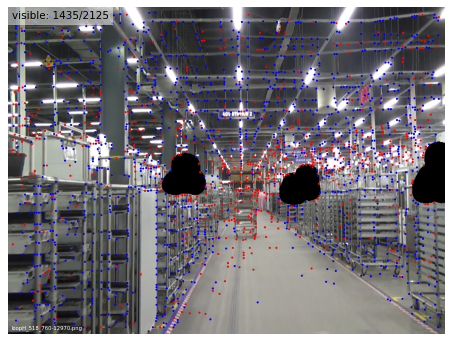

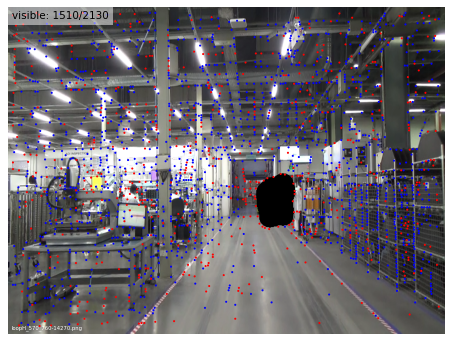

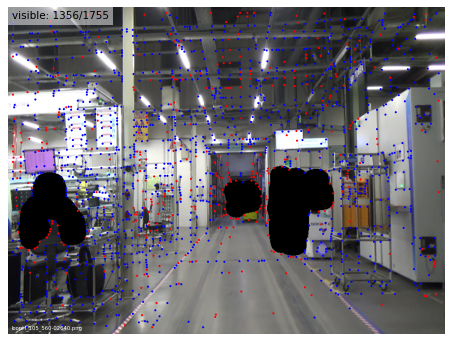

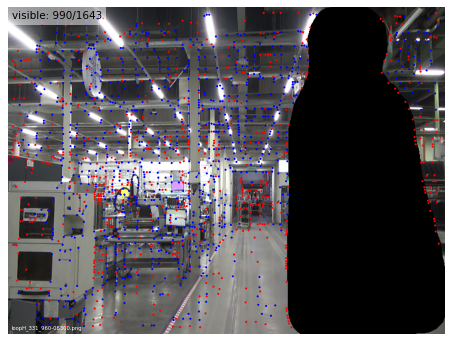

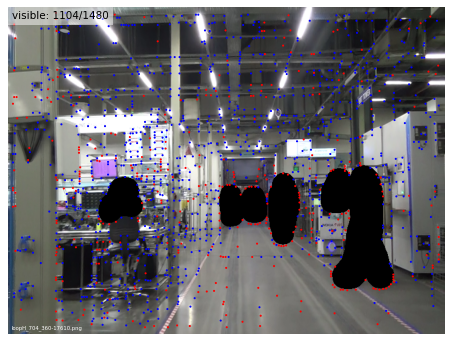

In [10]:
visualization.visualize_sfm_2d(sfm_dir / 'models/0', path_to_images_for_map, color_by='visibility', n=5)